In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from PIL import Image
from pycocotools.coco import COCO
from torch.utils.data import Dataset
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap

In [2]:
root = "/home/pervinco/Datasets/COCO2017"

In [3]:
class COCODataset(Dataset):
    def __init__(self, root, image_set='train', transforms=None):
        self.root = root
        self.image_dir = os.path.join(root, f"{image_set}2017")
        self.coco = COCO(os.path.join(root, f"annotations/instances_{image_set}2017.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']
        image_path = os.path.join(self.image_dir, path)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        height, width = image.shape[:2]
        # 모든 클래스 인덱스로 채워진 마스크를 저장할 배열을 생성합니다. 초기값은 0 (배경)입니다.
        mask = np.zeros((height, width), dtype=np.uint8)
        
        bboxes = []
        for obj in coco_annotation:
            # pycocotools에서 제공하는 annToMask 메서드를 사용하여 마스크를 생성합니다.
            obj_mask = self.coco.annToMask(obj)
            # 마스크에 클래스 인덱스를 적용합니다. 마스크의 해당 영역을 클래스 인덱스로 채웁니다.
            mask[obj_mask == 1] = obj['category_id']
            # 바운딩 박스 정보를 저장합니다. 여기에는 클래스 인덱스와 객체의 인덱스도 포함됩니다.
            bboxes.append(obj['bbox'] + [obj['category_id']] + [obj['id']])

        return image, bboxes, mask

In [4]:
dataset = COCODataset(root, image_set="val")

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [5]:
idx = random.randint(0, len(dataset)-1)
image, boxes, masks = dataset[idx] ## 1281

In [6]:
print(len(boxes), len(masks))
print(masks[0].shape)
print(np.unique(masks[0]))

3 375
(500,)
[0]


In [7]:
def draw_bboxes_and_masks(image, bboxes, mask, coco):
    image_copy = image.copy()
    fig, ax = plt.subplots(1)
    ax.imshow(image_copy)

    num_categories = len(coco.loadCats(coco.getCatIds()))
    cmap = ListedColormap([np.array([random.randint(0, 255) for _ in range(3)])/255.0 for _ in range(num_categories)])
    
    for bbox in bboxes:
        x, y, w, h, category_id, _ = bbox
        category_name = coco.loadCats(category_id)[0]['name']
        color = cmap(category_id % num_categories)
        
        rect = Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, category_name, fontsize=12, color='white', backgroundcolor=color)
    
    unique_classes = np.unique(mask)
    for cls in unique_classes:
        if cls == 0: continue  # 배경은 무시
        class_mask = (mask == cls)
        color = np.array(cmap(cls % num_categories)) * 255
        colored_mask = np.zeros_like(image_copy)
        
        for i in range(3):  # RGB 채널
            colored_mask[:,:,i] = class_mask * color[i]
        
        # 마스크를 이미지에 오버레이
        image_copy = cv2.addWeighted(image_copy, 1, colored_mask, 0.5, 0)
    
    ax.imshow(image_copy)
    plt.axis('off')
    plt.show()


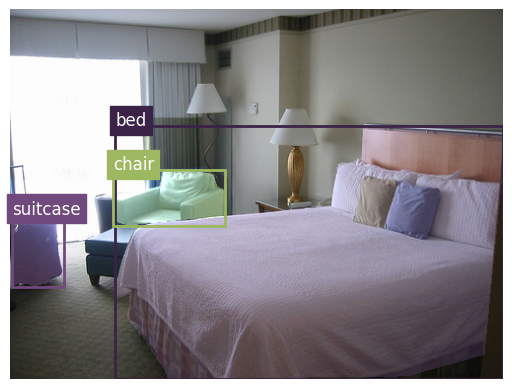

In [8]:
visualized_image = draw_bboxes_and_masks(image, boxes, masks, dataset.coco)